<a href="https://colab.research.google.com/gist/Toldry/8e9e524cba7b0bef5126e04fa5379032/categorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

We are Alon Eitan and Dor Daniel, students in the Open University of Israel.

In this project, we aim to create an image classification model for cat subreddits in the social media website Reddit.

Since we both never had a project with computer vision and we thought that this project is a great opportunity try somting new, plus Alon's love for cats and reddit and cats on reddit was unparalleled. His affection won Dor over so we decided to try to classify as many subreddit as posibile.

##The problem

 Reddit is a social media platform ,and its structure is a network of communities on people's interests. 
Its main use is sharing content for the people to see on a subreddits.

A subreddit is a specific online community that focuses on a topic, like cars , sports, coding problems and in our case: cats or onlyhappycats or CatsWithHats and even HistoricalCatLovers.

Our objective is to create a model that gets a picture of a cat as input, and outputs which subreddit(s) the picture fits the best. 

For example, if the model receives a picture of a [black cat wearing a hat](https://i.redd.it/f0brl1wvs6v51.jpg), then it may suggest that the picture fits in r/BlackCats and r/CatsWithHats.

Then, after the model is complete, we'll create a bot u/CATegorizer_bot, that automatically replies to cat pictures and gives suggestions to which cat subreddits it might fit best.

We know that our data set is too broad but still we want to try and see what can we do with it and what unexpected results we can discover. 

We plan to try a different ways to so, some of them include the libraries TensorFlow,Keras and ImageAI.

# Challenges

## Intersectionality
There is a large intersection between the content that can be found in different subreddits. For instance, this picture:

 <img src="https://i.redd.it/0cj4wyr1uc851.jpg" height="500px"/>

could be appropriately placed in any one of these subreddits:


* r/CatsOnKeyboards
* r/IllegallySmolCats
* r/tinyorangekittens
* r/Catswithjobs
* r/orangecats
* r/gingerkitty
* r/Cats

with the last subreddit r/Cats being truly all-encompassing.

It is therefore challenging to determine whether any particular picture not only fits a certain subreddit at all, but which of the subreddits that it does fit, are **most** fitting.


## Unrelated content
Despite reddit being neatly organized into different subreddits, each having a category of content that intuitively fits it, redditors often err and share content to a subreddit that doesn't strictly fit it's theme.

Other redditors who like the submission often choose to upvote it despite not fitting the theme of the subreddit, either because they didn't notice the mismatch or they simply don't care.

As a result, we find pictures of orange cats in r/BlackCats. This essentialy acts as mislabeled data for the purposes of our classification algorithm.


#Data collection

To collect the data, we wrote a scraper:
https://github.com/Toldry/CATegorizer/blob/main/scraper.py

It uses the Python library `praw`, to scans the top 1000 submissions of every cat subreddit.

The list `cat_subredditss.csv` was generated from the cat subreddit index:
https://www.reddit.com/r/Catsubs/wiki/index


The scraper first filtered the subreddits that are restricted or private or deleted, or had too few subscribers. The viable subreddits are in `filtered_cat_subs.csv`.

Each submission has many attributes related to it, most of which are irrelevant to our aim of classifying cat images. 
We arbitrarily chose the following attributes which we thought might be useful:
* id
* url
* permalink
* score
* title
* total_awards_received
* ups
* upvote_ratio
* is_original_content
* gilded
* num_comments
* num_crossposts
* num_duplicates
* over_18

The critical fields are `url` which links to the image, and `score` which shows how many people upvoted the submission.

The total number of submission we originally collected is 124,623. 

The scraper took roughly five days to collect all the data, not including the images themselves.

#Data cleanining


First we discarded all the posts with broken urls.
We leveraged the `concurrent.futures` multithreading library to accelrate the process of checking which urls are broken.

Without it it would have taken approximately 2 days to run, with it, it ran for only 4~5 hours.
Because the time to run was unknown we didnt run it in the notebook.

We exported the information of the broken urls to a .txt file so we could check some of the urls to see if they are broken before deleting them. 

We used 10 seconds for timeouts, luckily no timeouts occured.


In [ ]:
import requests
import pandas as pd
import numpy as np
import concurrent.futures
import urllib

In [ ]:
# def bad_url(a_url, an_index, timeout=10):
#     response = requests.get(url=a_url, timeout=timeout)
#     if response.status_code == 404:
#         #the plus 2 is for maching the index in df to the CSV file for easier confirmation
#         print(an_index + 2, 'ERROR')
#         return str(an_index + 2)
#     #the prining is for following the run
#     if (an_index % 2000 == 0 ):
#         print(an_index, ' done')
#     #when we returned noting or "" it bugd out
#     return " "


# if __name__ == '__main__':
#     f = open("broken_url.txt", "a",encoding="utf-8")
#     df = pd.read_csv('submission.csv')

#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         futures = []
#         for x in df.index:
#             futures.append(executor.submit(bad_url, a_url=df.loc[x, "url"], an_index=x))
#         #run on completed Threads output
#         for future in concurrent.futures.as_completed(futures):
#             try:
#                 f.write(future.result())
#             except requests.ConnectTimeout:
#                 print("ConnectTimeout.")
#     f.close()


in total, 528 broken urls were detected.


#Exploratory data analaysis

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = [20, 10] # Increase the figure size across the entire notebook

In [ ]:
# Get the data

SUBMISSIONS_URL = 'https://raw.githubusercontent.com/Toldry/CATegorizer/main/submission.csv'
data = pd.read_csv(SUBMISSIONS_URL)
data = data.set_index('id')

data.describe()

score  total_awards_received  ...  num_crossposts  num_duplicates
count  125078.000000          125078.000000  ...   125078.000000   125078.000000
mean     1169.404636               0.701099  ...        0.223349        0.465150
std      2568.936052               5.259843  ...        0.870128        1.663655
min         0.000000               0.000000  ...        0.000000        0.000000
25%        77.000000               0.000000  ...        0.000000        0.000000
50%       277.000000               0.000000  ...        0.000000        0.000000
75%       982.000000               0.000000  ...        0.000000        0.000000
max     71658.000000             522.000000  ...       27.000000       51.000000

[8 rows x 8 columns]

In [ ]:
data.columns

Index(['subreddit_name', 'url', 'permalink', 'score', 'title',
       'total_awards_received', 'ups', 'upvote_ratio', 'is_original_content',
       'gilded', 'num_comments', 'num_crossposts', 'num_duplicates',
       'over_18'],
      dtype='object')

In [ ]:
# Number of different subreddits:
len(data['subreddit_name'].unique())

346

We filter out submission that doesn't have some minimum number of upvotes, because such submissions are less likely to be reliably relevant to their respective subreddit, or be relevant at all.

In [ ]:
MINIMUM_SCORE_THRESHOLD = 100
score_below_minimum = data['score'] < MINIMUM_SCORE_THRESHOLD
print(score_below_minimum.value_counts())

False    88158
True     36920
Name: score, dtype: int64


The most important value we can use to judge how "good" or "fitting the subreddit" a single submission is by looking at the number of **upvotes** it has.

In the dataset, this info is in the `score` column:

In [ ]:
grouped = data.groupby('subreddit_name')
result = grouped.agg({'score': ['mean', 'min', 'max']})
result = result.sort_values(('score', 'max'), ascending=False)
result['score']

mean    min    max
subreddit_name                               
Cats               19493.501269  15038  71658
Chonkers           10951.398252   6416  48697
Meow_Irl           10433.070857   6923  34105
CatsWhoYell        10596.463710   5831  33759
StartledCats       12587.205882   7307  29284
...                         ...    ...    ...
CatQueries             3.428571      0      9
FelineCare             3.550000      1      6
CatsFailingJumps       6.000000      6      6
CatsStuckInThings      3.500000      1      6
Cathletes              4.000000      4      4

[346 rows x 3 columns]

Let's take a look at the number of upvotes each subreddit's most upvoted submission has:

Text(0, 0.5, 'Number of subreddits in maximum score bin')

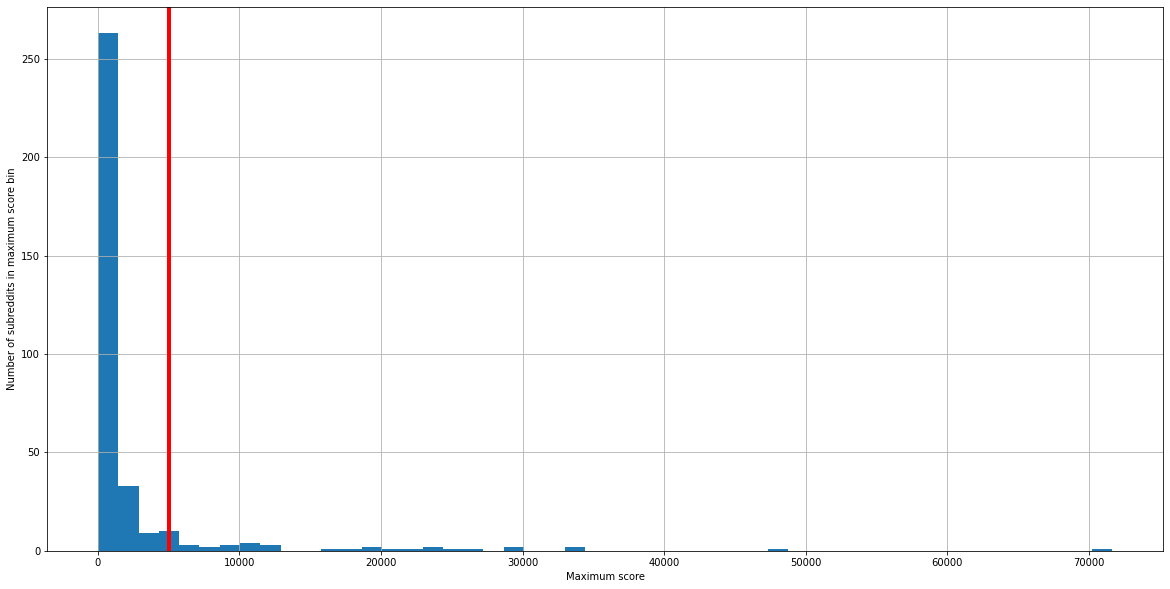

In [ ]:
result2 = result['score']['max']
result2.hist(bins=50)
plt.axvline(5000, color='r', linewidth=4)
plt.xlabel('Maximum score')
plt.ylabel('Number of subreddits in maximum score bin')

The vast majority of subreddit's most upvoted submission has a score that is below 5000. (Left of the red line)

Let's take a more granular look at those subreddits:

Text(0, 0.5, 'Number of subreddits in maximum score bin')

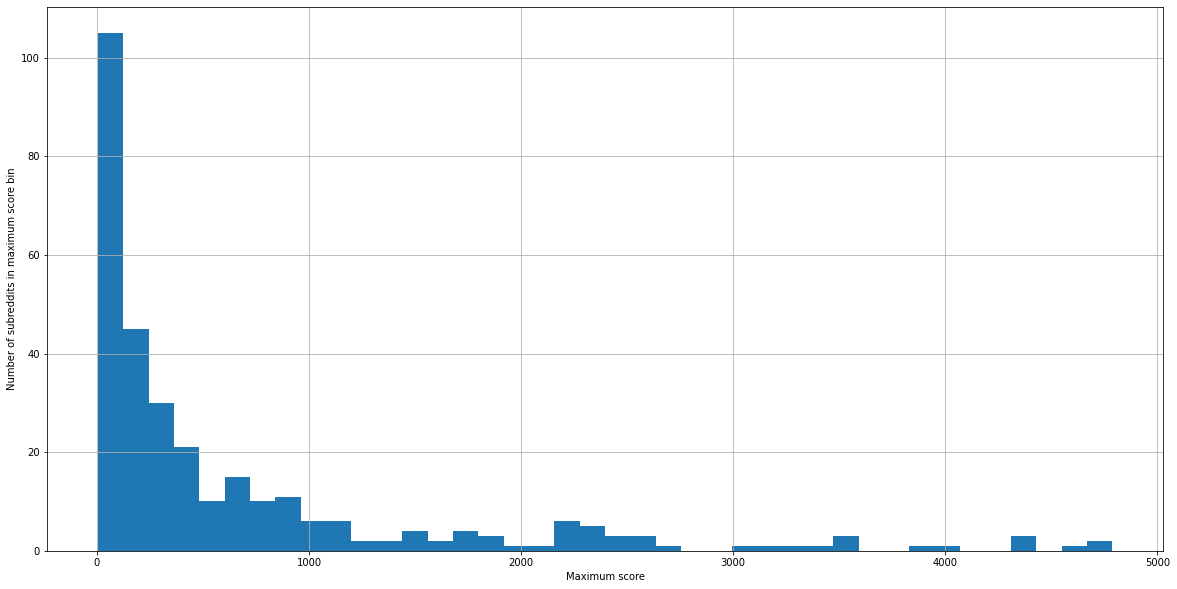

In [ ]:
result3 = result2[result2 < 5000]
result3.hist(bins=40)
plt.xlabel('Maximum score')
plt.ylabel('Number of subreddits in maximum score bin')

When the top submission has fewer than 1000 upvotes, it indicates that the subreddit is not very popular. 

## Numerical fields

In [ ]:
numerical_classes = ['score', 'total_awards_received', 'ups', 'upvote_ratio', 'gilded', 'num_comments', 'num_crossposts', 'num_duplicates']
df2 = data[numerical_classes]
normalized = ((df2 - df2.mean()) / df2.std())
normalized

score  total_awards_received  ...  num_crossposts  num_duplicates
id                                       ...                                
kodzf7 -0.292107               0.056827  ...       -0.256685       -0.279595
lwk2qq -0.328698               0.056827  ...       -0.256685       -0.279595
clcd2p -0.344658              -0.133293  ...        0.892572        0.321491
goit9q -0.350886              -0.133293  ...       -0.256685        0.321491
kxctgx -0.354390              -0.133293  ...       -0.256685       -0.279595
...          ...                    ...  ...             ...             ...
pdaon  -0.452096              -0.133293  ...       -0.256685        0.321491
pda5i  -0.452096              -0.133293  ...       -0.256685       -0.279595
pkxou  -0.452096              -0.133293  ...       -0.256685       -0.279595
5l1ole -0.453263              -0.133293  ...       -0.256685       -0.279595
poika  -0.453653              -0.133293  ...       -0.256685       -0.279595

[125078 rows x 8 columns]

##Binary Fields

The dataset includes only two binary fields: `is_original_content` and `over_18`

In [ ]:
print(data['is_original_content'].value_counts())

False    124857
True        221
Name: is_original_content, dtype: int64


It well known by redditors that the majority of the posts in reddit are reposts, meaning that they are not original content.

However, it is surprisng to see that such a tiny fraction 221/124857 $\approx$ 0.001 of posts are marked as "original content".

Upon closer inspection, the `is_original_content` field appears to be [a rarely-used feature accessible only to moderators](https://www.reddit.com/r/redesign/comments/8a48uv/moderators_try_marking_posts_as_oc_on_the_redesign/), which explains why there are so few posts that are marked as OC.




In [ ]:
print(data['over_18'].value_counts())

False    124287
True        791
Name: over_18, dtype: int64


The `over_18` flag, also known as the "NSFW" flag (not safe for work) is used by both users and moderators to mark content that may contain nudity, intense sexuality, political incorrectness, profanity, slurs, violence or other potentially disturbing subject matter 

Seeing as our subject matter is cats, it makes sense that very few posts in our data are marked as `over_18`.



Since both flags don't contribute almost at all to the data, we can safely drop both of them.

In [ ]:
columns_to_remove = ['is_original_content', 'over_18']

## Text fields

The only text field in the dataset is `title`.

One venue to explore may be to use NLP techniques to extract useful information from title of the submission.

For now, we'll look at the simplest feature: length

       subreddit_name                                  url  ... over_18  title_len
id                                                          ...                   
kodzf7        catsubs  https://i.redd.it/eog5205syq861.jpg  ...   False         53
lwk2qq        catsubs  https://i.redd.it/8mcvaqsxfqk61.jpg  ...   False         94
clcd2p        catsubs      https://i.imgur.com/427vpjE.jpg  ...   False         19
goit9q        catsubs  https://i.redd.it/d20yl18pcb051.jpg  ...   False         32
kxctgx        catsubs  https://i.redd.it/qdhnttwqncb61.jpg  ...   False         81
...               ...                                  ...  ...     ...        ...
pdaon   onlyhappycats         http://i.imgur.com/GbeFh.jpg  ...   False         43
pda5i   onlyhappycats         http://i.imgur.com/3BMBI.jpg  ...   False         22
pkxou   onlyhappycats         http://i.imgur.com/vwlFr.jpg  ...   False         33
5l1ole  onlyhappycats   https://i.redd.it/y2qi5d0t0n6y.jpg  ...   False         41
poik

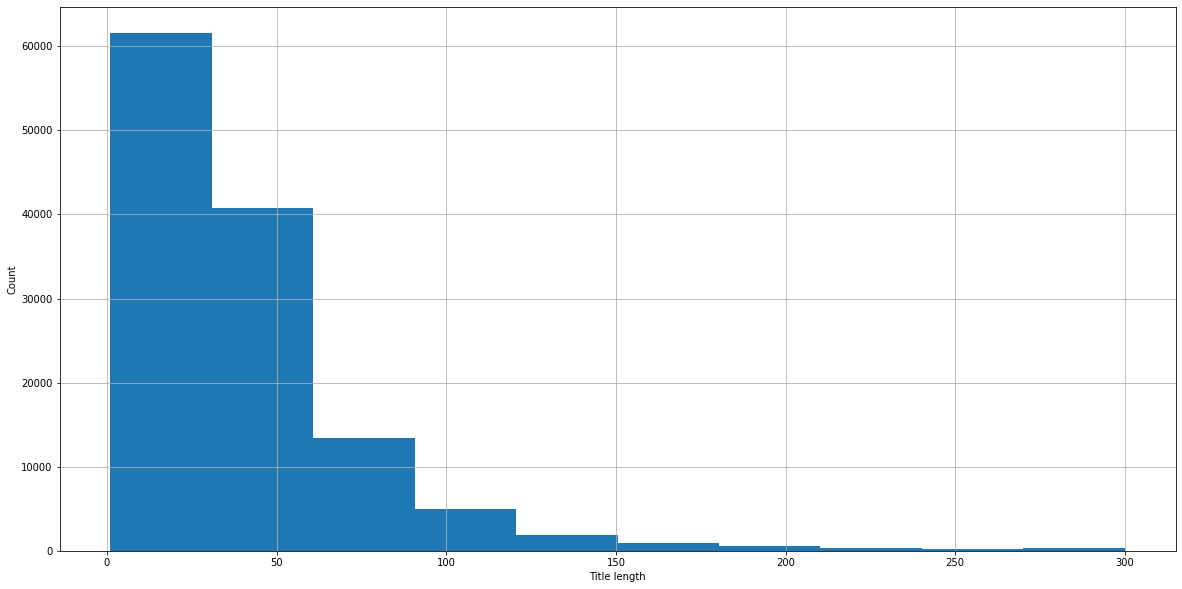

In [ ]:
data['title_len'] = data['title'].str.len()
numerical_classes += ['title_len']
data['title_len'].hist()
plt.xlabel('Title length')
plt.ylabel('Count')
print(data)

Reddit's 300 character limit is apparent from this graph.

From our familiarty with reddit, we expect that submissions with longer title lengths will have more awards given, because very long titles usually imply a long-winded heartbreaking story about a rescue cat that survived cancer or something.

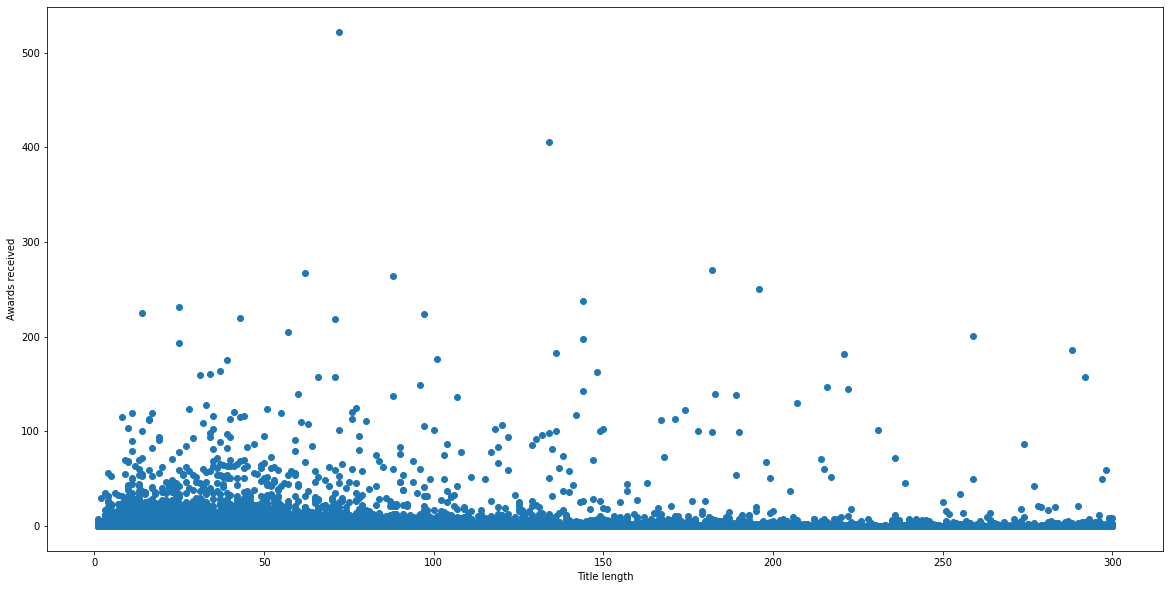

In [ ]:
plt.scatter(data['title_len'], data['total_awards_received'])
plt.xlabel('Title length')
plt.ylabel('Awards received')
plt.show()

Surprisngly, as apparent from this graph, our prediction was proven wrong.
Reddit users give more wards to submissions with shorter titles.

The most-awarded submission with 522 awards is this photo with the title `"She has a lucky sock. Very necessary when monitoring the bird situation."`

  <img src="https://i.redd.it/q4yn8cw1tbi61.jpg" height="400px"/>

the human mind works in mysterious ways.


##Other Fields

`score` and `ups` contain the same data:


In [ ]:
(data['score'] - data['ups']).value_counts()

0    125078
dtype: int64

Therefore we drop the `ups` field.

In [ ]:
columns_to_remove += ['ups']

`upvote_ratio` is a field that was used in the past, but was discontinued :
https://www.reddit.com/r/announcements/comments/28hjga/reddit_changes_individual_updown_vote_counts_no/

In [ ]:
columns_to_remove += ['upvote_ratio']

`gilded` and `total_awards_received` are both bought with money , and they could be exploited. 
we could not find any relevent information frome both of them.

we belive that the fields `num_comments`,`num_crossposts`,`num_duplicates` may have some correlation to the success chance of the model so we will check it in the future 

# Filteration

We filter the following rows:
* Duplicates
* Broken urls
* Score below minimum threshold (`score_below_minimum`)
* Submissions belonging to subreddits with top post which has a score below minmum threshold (`subreddits_below_minimum_threshold`)

and the columns:
* is_original_content
* over_18
* ups
* upvote_ratio

In [ ]:
#after resting index set it again
data = pd.read_csv(SUBMISSIONS_URL)
data3 = data.drop_duplicates(subset=['id'])
data3 = data3.set_index('id')
print(f'Duplicates removed: {len(data) - len(data3)}')


index_to_delete = []
BROKEN_URLS = 'https://raw.githubusercontent.com/Toldry/CATegorizer/main/broken_url_by_id.txt'
with urllib.request.urlopen(BROKEN_URLS) as file:
  for line in file:
    decoded_line = line.decode('utf-8')
    decoded_line = decoded_line[0:-1] # remove newline
    index_to_delete += [decoded_line]

data4 = data3.drop(index_to_delete)
print(f'Broken url rows removed: {len(data3)- len(data4)}')


data5 = data4.drop((data4[data4['score'] < MINIMUM_SCORE_THRESHOLD]).index)
print(f'Score below minimum threshold rows removed: {len(data4)- len(data5)}')


data6 = data5.drop(columns=columns_to_remove)
print(f'Dropped columns: {str(columns_to_remove)}')


Duplicates removed: 4419
Broken url rows removed: 492
Score below minimum threshold rows removed: 36217
Dropped columns: ['is_original_content', 'over_18', 'ups', 'ups', 'upvote_ratio', 'upvote_ratio']


Since we have a limited amount of resources, we limit the number of subreddits we will analyse, whose images we will download:

In [ ]:
NUM_OF_SUBREDDITS_TO_KEEP = 20

sub_counts = data6['subreddit_name'].value_counts()
subreddits_to_keep = sub_counts[:NUM_OF_SUBREDDITS_TO_KEEP].index
subreddits_to_keep = set(subreddits_to_keep)

# Include these subreddits for future analysis
subreddits_for_future_PCA = set(['BattleCats',
'SphynxCats',
'BlackCats',
'FromKittenToCat',
'purrito',
'TuxedoCats',])

subreddits_to_keep = subreddits_to_keep.union(subreddits_for_future_PCA)

subreddits_to_keep = list(subreddits_to_keep)

data7 = data6[data6['subreddit_name'].isin(subreddits_to_keep)]

print(f'Subreddits outside the top subreddits, rows removed: {len(data6)- len(data7)}')
print(f'Subreddits to keep:')
   
for sub in subreddits_to_keep:
  print(sub)

Subreddits outside the top subreddits, rows removed: 63277
Subreddits to keep:
purrito
BlackCats
SupermodelCats
Kitty
Floof
SphynxCats
scrungycats
blurrypicturesofcats
PottedCats
catfruit
BattleCats
Catbun
shrimping
CatLoaf
TuxedoCats
PeanutWhiskers
CatMemes
CatPictures
JellybeanToes
WarriorCats
FromKittenToCat
CatsSittingDown
curledfeetsies


In [ ]:
#Save filtered data to csv
filtered_data = data7
print(f'Number of rows: {len(filtered_data)}')
filtered_data.to_csv('filtered_submissions.csv')

Number of rows: 20673


# Downloading the images

We download the images directly from the url, organize them into folders according to subreddit, and each file is named after the id of the submission. 

We use multithreading (with `concurrent.futures.ThreadPoolExecutor`) to reduce the amount of time it takes to download all of the images.

In [ ]:
from pathlib import Path
import os
cwd = os.getcwd()
print(cwd)

images_path = Path(cwd + '/images')
images_path.mkdir(parents=True, exist_ok=True)

/content


In [ ]:
DOWNLOAD_FROM_REDDIT = True

In [ ]:
%%time

if DOWNLOAD_FROM_REDDIT:
  from tqdm.notebook import tqdm
  subreddits = subreddits_to_keep


  import re
  image_suffixes = ['png', 'jpg', 'jpeg']
  image_rx = re.compile('.*\.(' + '|'.join([f'{str}' for str in image_suffixes]) + ')$')

  def download_or_skip(url, filename):
    if not os.path.isfile(filename):
      return urllib.request.urlretrieve(url=url, filename=filename)


  import urllib
  for sub in subreddits:
    sub_path = Path(cwd + '/images/' + sub)
    sub_path.mkdir(parents=True, exist_ok=True)
    submissions = filtered_data[filtered_data['subreddit_name'].str.lower() == sub.lower()]
    with concurrent.futures.ThreadPoolExecutor() as executor:
      futures = []
      for index, row in submissions.iterrows():
        url = row['url']
        id = index
        suffix = image_rx.match(url).groups()[0]
        image_path = str(sub_path) +'/' + id + '.' + suffix
        futures.append(executor.submit(download_or_skip, url=url, filename=image_path))
      with tqdm(total=len(futures), desc=sub) as pbar:
        for future in concurrent.futures.as_completed(futures):
          try:
              future.result()
              pbar.update(1)
          except Exception as e:
            pass


CPU times: user 3min 42s, sys: 3min 33s, total: 7min 15s
Wall time: 6min 41s


## Downloading from Google Drive

In the span of a week, I downloaded 42GB of cat pictures from almost 100 subreddits. They're currently stored in my Google Drive for easy access through this colab notebook.

However, it appears this did not help speeding up the development of this project, so the next cells do not run.

In [ ]:
MOUNT_GOOGLE_DRIVE = False

In [ ]:
if MOUNT_GOOGLE_DRIVE:
  from google.colab import drive
  drive.mount('/gdrive')

  # Import PyDrive and associated libraries.
  # This only needs to be done once per notebook.
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # Authenticate and create the PyDrive client.
  # This only needs to be done once per notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

In [ ]:
if MOUNT_GOOGLE_DRIVE:
  images_path= '/gdrive/MyDrive/Academic/Data Science Workshop/CATegorizer/images/'
  # images_path= '/gdrive/'

  from os import listdir
  from os.path import isfile, join
  onlyfiles = [f for f in listdir(images_path) if isfile(join(images_path, f))]
  import glob
  print(glob.glob(images_path + '/**'))
  print('done')

#Principal Component Analysis

We sample images from an arbitrarily selected list of subreddits, and perform PCA on them after rescaling and normalizing their pixel values

Let's take a look at some example submissions from each subreddit:

In [ ]:
from sklearn.decomposition import PCA
import cv2
import glob
import pathlib
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

color_map = {'BattleCats': 'red', 
             'SphynxCats': 'yellow',
             'BlackCats': 'black', 
             'FromKittenToCat': 'green',
             'purrito': 'purple',
             'TuxedoCats': 'blue',
}

subreddits = list(color_map.keys())

img_height = 180
img_width = 180

random.seed(1)

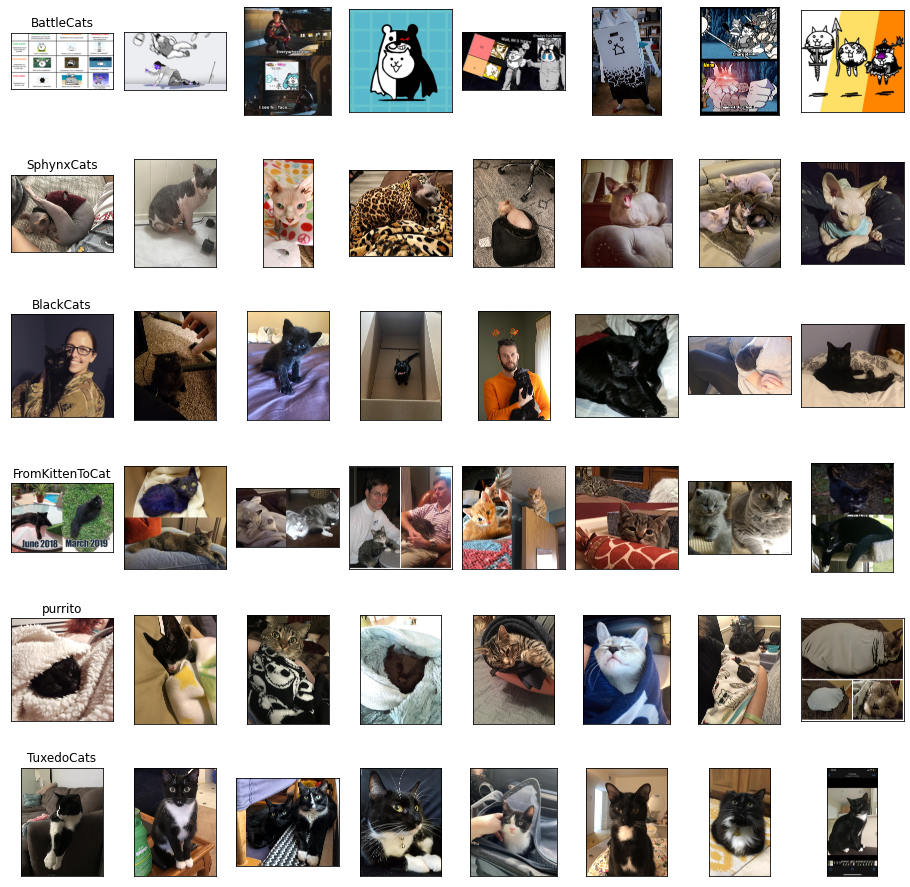

In [ ]:
NUM_EXAMPLES = 8

fig, axes = plt.subplots(len(subreddits),NUM_EXAMPLES,figsize=(16,16),
  subplot_kw={'xticks':[], 'yticks':[]},
  gridspec_kw=dict(hspace=0.4, wspace=0.1))

i=0
for sub in subreddits:
  subreddit_folder = str(images_path) + '/' + sub
  subreddit_submission_files = glob.glob(subreddit_folder + '/*.*')
  random.shuffle(subreddit_submission_files)
  selected_images = subreddit_submission_files[:NUM_EXAMPLES]
  for imfile in selected_images:
    img = cv2.cvtColor(cv2.imread(imfile),cv2.COLOR_BGR2RGB)
    # res = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_CUBIC)
    ax = axes.flat[i]
    ax.imshow(img)
    if i%NUM_EXAMPLES == 0: 
      ax.set_title(sub)
    i+=1

Now let's perform PCA on a subset of images from each subreddit, and see whether if any internal structure reveals itself

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


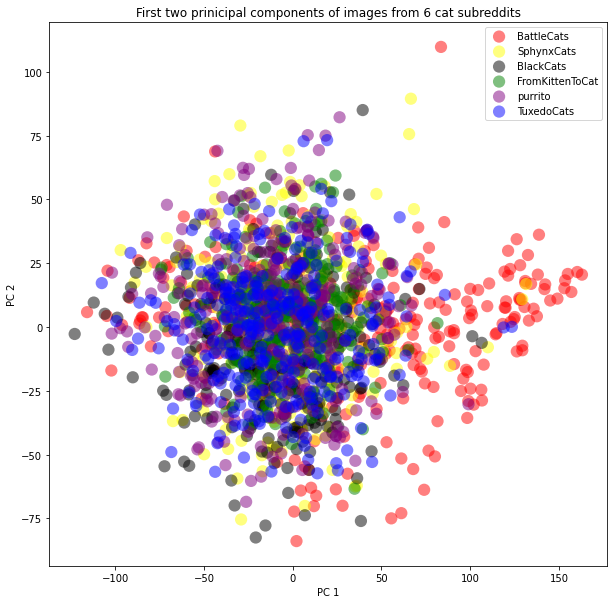

In [ ]:
%time

SELECTION_SIZE_PER_SUBREDDIT = 300

targets = []
images = []

for sub in subreddits:
  subreddit_folder = str(images_path) + '/' + sub
  subreddit_submission_files = glob.glob(subreddit_folder + '/*.*')
  random.shuffle(subreddit_submission_files)
  selected_images = subreddit_submission_files[:SELECTION_SIZE_PER_SUBREDDIT]
  for imfile in selected_images:
    img = cv2.cvtColor(cv2.imread(imfile),cv2.COLOR_BGR2RGB)
    try:
      res = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_CUBIC)
    except:
      continue
    res = np.array(res).flatten()
    #normalize values
    res = res/255 
    images += [res]
    targets += [sub]



pca = PCA(6) 
projected = pca.fit_transform(images)

df = pd.DataFrame(projected,
                  columns=['PC 1',
                           'PC 2',
                           'PC 3',
                           'PC 4',
                           'PC 5',
                           'PC 6'])


df['subreddit'] = targets

fig, ax = plt.subplots()
for sub,c in color_map.items():
    filtered = df[(df['subreddit'] == sub)]
    ax.scatter(filtered['PC 1'], filtered['PC 2'], c=c, s=150, label=sub,
               alpha=0.5, edgecolors='none')

ax.legend()
plt.title('First two prinicipal components of images from 6 cat subreddits')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

ax.figure.set_size_inches(10,10)
plt.show()

As visible from the plot, the only meaningful distinction that can be drawn between the different subreddits in terms of their principal component clusters are between *r/BattleCats* and the rest of the subreddits.

This makes sense, since *r/BattleCats* is a subreddit filled with meme-format images rather than photos of cats.


This is a rather disappointing result, since we might've hoped that the PCA would've detected differences between subreddits such as *r/BlackCats* and *r/TuxedoCats* because the former's color is predominantly black, and the latter's color is both black and white.


Better results can possibly be achieved by better utilizing the RGB channels in each photo, or by converting the photos to greyscale.

We move on to observe the explained variance of each consecutive component

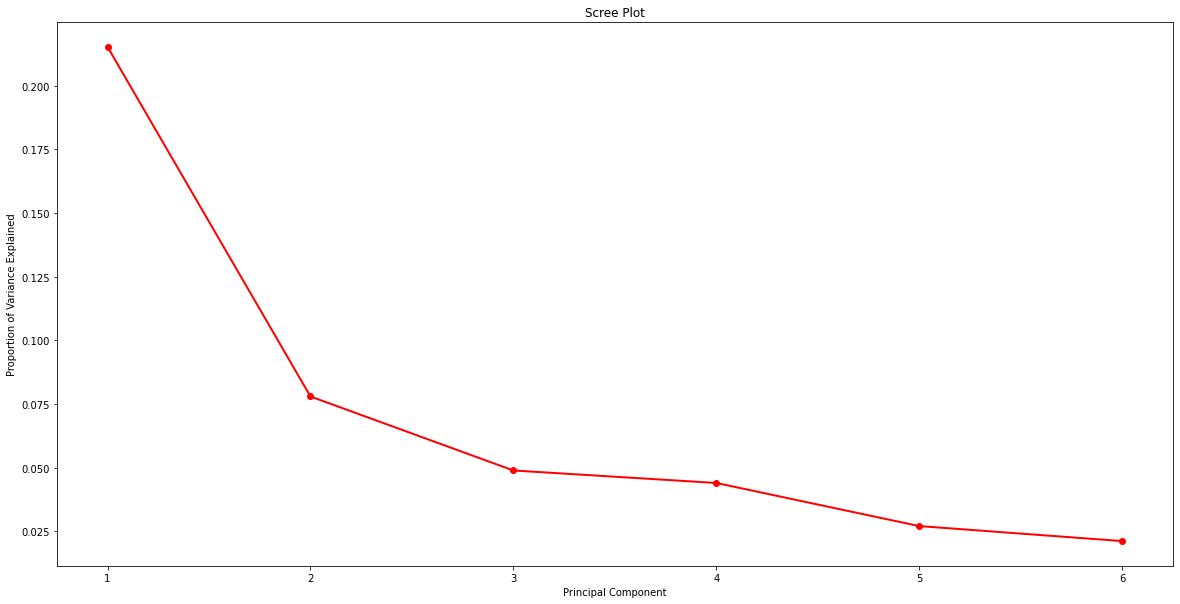

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

The "elbow" of the graph is at $n=2$ components, meaning that the first PC explains a relatively larger proportion of the variance in the images.

Despite this, the explanatory power of the first PC is very small:

In [ ]:
sum(pca.explained_variance_ratio_)

0.43421008037160747

 Even with all the 6 PCs combined, less than $0.5$ of the variance is explained.

This can be visually represented by viewing the principal components as images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


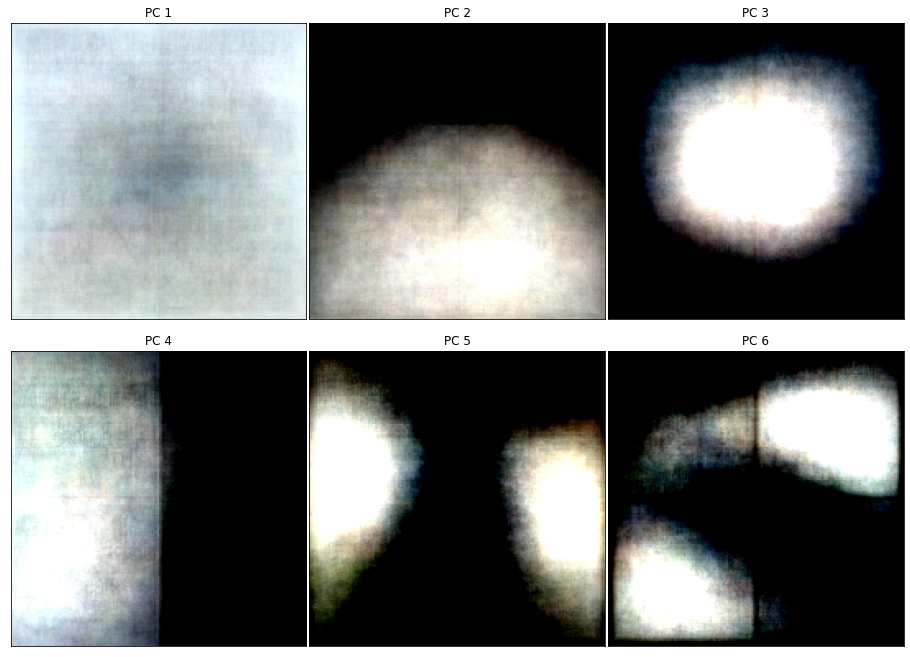

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(16,12),
  subplot_kw={'xticks':[], 'yticks':[]},
  gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
  ax.imshow(pca.components_[i].reshape(img_width,img_height, 3) * 255)
  ax.set_title(f'PC {i+1}')

Nothing distinctly cat-like emerges from these rorschach-test-like blotches.

# Image classification with Keras: SphynxCats VS BlackCats

Keras is a machine learning library that is natively supported in google colab. 

We will use the `Sequential` model to create a convoloutional neural network that will classify the cat images into subreddits.

We chose to use Keras since it is an accessible tool that offers a clear API, and natively supports various optimizations that allow the training to run quickly.



We limit the scope of our first image classification attempt to the two subreddits `'SphynxCats', 'BlackCats'`.

First we split our data to a train and test sets:
 

In [ ]:
!rm -rf images2

In [ ]:
import random
import math
import shutil
import os
from pathlib import Path

cwd = os.getcwd()

SPLIT_PERCENTAGE = 0.2

subreddits = ['SphynxCats', 'BlackCats']
# subreddits = subreddits_to_keep

p2 = Path(cwd + '/images2')
p2.mkdir(parents=True, exist_ok=True)


for sub in subreddits:
  random.seed(1)
  sub_path1 = Path(cwd + '/images/' + sub)
  sub_path2 = Path(cwd + '/images2/' + sub)
  sub_path2.mkdir(parents=True, exist_ok=True)
  files = os.listdir(sub_path1)
  random.shuffle(files)
  num_files = len(files)
  split_point = math.floor(num_files * SPLIT_PERCENTAGE)
  test = files[:split_point]
  train = files[split_point+1:]
  print(f'Num test files in sub {sub}: {len(test)}')
  print(f'Num train files in sub {sub}: {len(train)}')
  test_folder_path = str(sub_path2) + '/test'
  train_folder_path = str(sub_path2) + '/train'
  Path(test_folder_path).mkdir(parents=True, exist_ok=True)
  Path(train_folder_path).mkdir(parents=True, exist_ok=True)
  for f in test:
    image_soruce_path = str(sub_path1) + '/' + f
    image_target_path = test_folder_path + '/' + f
    shutil.copy(image_soruce_path, image_target_path)
  for f in train:
    image_soruce_path = str(sub_path1) + '/' + f
    image_target_path = train_folder_path + '/' + f
    shutil.copy(image_soruce_path, image_target_path)


Num test files in sub SphynxCats: 128
Num train files in sub SphynxCats: 514
Num test files in sub BlackCats: 182
Num train files in sub BlackCats: 727


In [ ]:
# based on https://www.tensorflow.org/tutorials/images/classification
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


batch_size = 32
img_height = 180
img_width = 180


data_dir = Path(cwd + '/images2')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1551 files belonging to 2 classes.
Using 1241 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1551 files belonging to 2 classes.
Using 310 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)


['BlackCats', 'SphynxCats']


Here's a sample of images from the dataset:

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


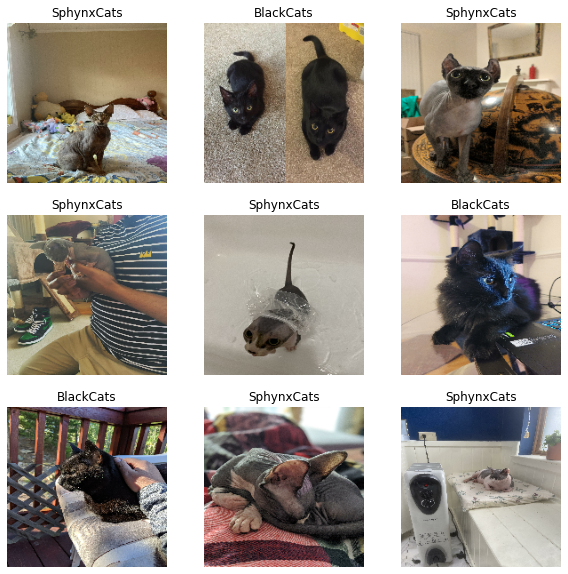

In [ ]:
import matplotlib.pyplot as plt


print(train_ds)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Use Keras's builtin buffered prefetching to increase training performance:

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Model definition

In [ ]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


The first layer of the model rescales the pixel values from `[0,255]` to `[0,1]` to work better with the neural network.


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Training

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
39/39 [==============================] - 76s 1s/step - loss: 0.6243 - accuracy: 0.6946 - val_loss: 0.3672 - val_accuracy: 0.8387
Epoch 2/10
39/39 [==============================] - 38s 970ms/step - loss: 0.3554 - accuracy: 0.8598 - val_loss: 0.3431 - val_accuracy: 0.8613
Epoch 3/10
39/39 [==============================] - 38s 964ms/step - loss: 0.3081 - accuracy: 0.8840 - val_loss: 0.3328 - val_accuracy: 0.8742
Epoch 4/10
39/39 [==============================] - 38s 967ms/step - loss: 0.2697 - accuracy: 0.8952 - val_loss: 0.3465 - val_accuracy: 0.8677
Epoch 5/10
39/39 [==============================] - 38s 967ms/step - loss: 0.2046 - accuracy: 0.9218 - val_loss: 0.4285 - val_accuracy: 0.8290
Epoch 6/10
39/39 [==============================] - 38s 969ms/step - loss: 0.1591 - accuracy: 0.9460 - val_loss: 0.3662 - val_accuracy: 0.8613
Epoch 7/10
39/39 [==============================] - 38s 971ms/step - loss: 0.1104 - accuracy: 0.9605 - val_loss: 0.5180 - val_accuracy: 0.8097
Ep

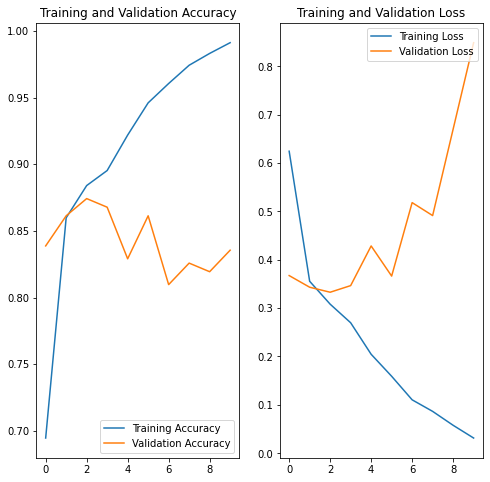

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


After visualizing the results we can see thet the training accuracy approaches 1 while the validation accuracy is stuck below 0.9. This is evidence of overfitting.

Additionally, the validation loss has a V shape and is consistently higher than training loss, which approaches 0. This is another telltale sign of overfitting.

## Retrying with augmented data

Using data augmentation, we might be able to reduce overfitting by generating more data to feed into the model

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Here's what the augmentation looks like:

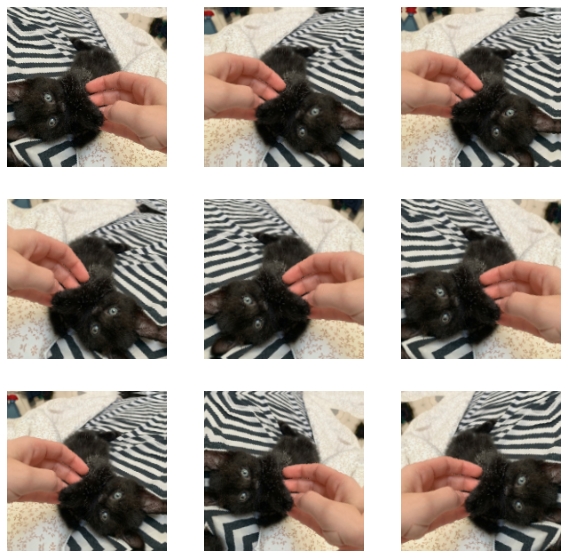

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

We redefine the model to include the data augmentation layers

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
39/39 [==============================] - 45s 1s/step - loss: 0.6896 - accuracy: 0.6358 - val_loss: 0.3901 - val_accuracy: 0.8452
Epoch 2/10
39/39 [==============================] - 43s 1s/step - loss: 0.3962 - accuracy: 0.8421 - val_loss: 0.3918 - val_accuracy: 0.8387
Epoch 3/10
39/39 [==============================] - 44s 1s/step - loss: 0.3627 - accuracy: 0.8678 - val_loss: 0.3256 - val_accuracy: 0.8548
Epoch 4/10
39/39 [==============================] - 44s 1s/step - loss: 0.3426 - accuracy: 0.8598 - val_loss: 0.3454 - val_accuracy: 0.8742
Epoch 5/10
39/39 [==============================] - 43s 1s/step - loss: 0.3268 - accuracy: 0.8687 - val_loss: 0.3472 - val_accuracy: 0.8742
Epoch 6/10
39/39 [==============================] - 43s 1s/step - loss: 0.3267 - accuracy: 0.8678 - val_loss: 0.3185 - val_accuracy: 0.8677
Epoch 7/10
39/39 [==============================] - 43s 1s/step - loss: 0.3178 - accuracy: 0.8719 - val_loss: 0.3146 - val_accuracy: 0.8613
Epoch 8/10
39/39 [==

We now compare the validation and test accuracy and loss. 

**BA stands for "Before Augmentation"**

**AA stands for "After Augmentation"**

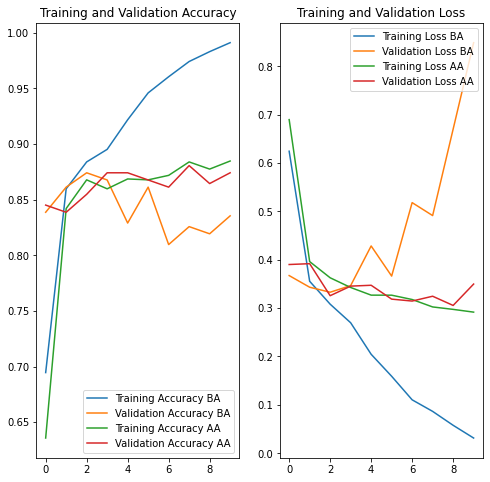

In [ ]:
acc_after_augmentation = history.history['accuracy']
val_acc_after_augmentation = history.history['val_accuracy']

loss_after_augmentation = history.history['loss']
val_loss_after_augmentation = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy BA')
plt.plot(epochs_range, val_acc, label='Validation Accuracy BA')
plt.plot(epochs_range, acc_after_augmentation, label='Training Accuracy AA')
plt.plot(epochs_range, val_acc_after_augmentation, label='Validation Accuracy AA')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss BA')
plt.plot(epochs_range, val_loss, label='Validation Loss BA')
plt.plot(epochs_range, loss_after_augmentation, label='Training Loss AA')
plt.plot(epochs_range, val_loss_after_augmentation, label='Validation Loss AA')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As is apparent from the above comparison, the data augmentation did not significantly improve the model's results.

Despite the overfitting, we can use the model to classify an image that wasn't included in the training or validation sets.

In [ ]:
cat1_url = "https://upload.wikimedia.org/wikipedia/commons/e/e8/Sphinx2_July_2006.jpg"
cat2_url = "https://upload.wikimedia.org/wikipedia/commons/4/4c/Blackcat-Lilith.jpg"
cat1_path = tf.keras.utils.get_file('wikipedia_sphynxcat', origin=cat1_url)
cat2_path = tf.keras.utils.get_file('wikipedia_blackcat', origin=cat2_url)

img1 = keras.preprocessing.image.load_img(
    cat1_path, target_size=(img_height, img_width)
)
img2 = keras.preprocessing.image.load_img(
    cat2_path, target_size=(img_height, img_width)
)

122880/116107 [===============================] - 0s 0us/step


In [ ]:
img_array1 = keras.preprocessing.image.img_to_array(img1)
img_array2 = keras.preprocessing.image.img_to_array(img2)
img_array1 = tf.expand_dims(img_array1, 0) # Create a batch
img_array2 = tf.expand_dims(img_array2, 0) # Create a batch


prediction1 = model.predict(img_array1)
prediction2 = model.predict(img_array2)
score1 = tf.nn.softmax(prediction1[0])
score2 = tf.nn.softmax(prediction2[0])

(-0.5, 179.5, 179.5, -0.5)

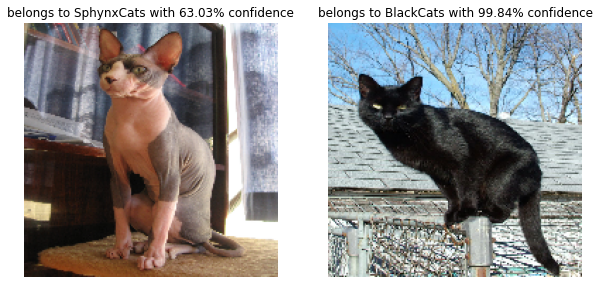

In [ ]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1,2,1)
ax.set_title(f'belongs to {class_names[np.argmax(score1)]} with {100 * np.max(score1):.2f}% confidence')
plt.imshow(img1)
plt.axis("off")
ax = plt.subplot(1,2, 2)
ax.set_title(f'belongs to {class_names[np.argmax(score2)]} with {100 * np.max(score2):.2f}% confidence')
plt.imshow(img2)
plt.axis("off")

As evident from the above cell, the model succesfuly clasified both cats in their respective subreddits.

#Image classification with Keras on all subreddits

In [ ]:
import random
import math
import shutil
import os
from pathlib import Path

cwd = os.getcwd()

SPLIT_PERCENTAGE = 0.2

subreddits = filtered_data['subreddit_name'].unique()

p2 = Path(images_path)

for sub in subreddits:
  random.seed(1)
  sub_path1 = Path(str(p2) + '/'  + sub)
  sub_path2 = Path(cwd + '/images2/' + sub)
  sub_path2.mkdir(parents=True, exist_ok=True)
  files = os.listdir(sub_path1)
  random.shuffle(files)
  num_files = len(files)
  split_point = math.floor(num_files * SPLIT_PERCENTAGE)
  test = files[:split_point]
  train = files[split_point+1:]
  print(f'Num test files in sub {sub}: {len(test)}')
  print(f'Num train files in sub {sub}: {len(train)}')
  test_folder_path = str(sub_path2) + '/test'
  train_folder_path = str(sub_path2) + '/train'
  Path(test_folder_path).mkdir(parents=True, exist_ok=True)
  Path(train_folder_path).mkdir(parents=True, exist_ok=True)
  for f in test:
    image_soruce_path = str(sub_path1) + '/' + f
    image_target_path = test_folder_path + '/' + f
    shutil.copy(image_soruce_path, image_target_path)
  for f in train:
    image_soruce_path = str(sub_path1) + '/' + f
    image_target_path = train_folder_path + '/' + f
    shutil.copy(image_soruce_path, image_target_path)


Num test files in sub Kitty: 180
Num train files in sub Kitty: 719
Num test files in sub FromKittenToCat: 160
Num train files in sub FromKittenToCat: 643
Num test files in sub CatPictures: 182
Num train files in sub CatPictures: 731
Num test files in sub SupermodelCats: 181
Num train files in sub SupermodelCats: 726
Num test files in sub blurrypicturesofcats: 192
Num train files in sub blurrypicturesofcats: 768
Num test files in sub CatsSittingDown: 178
Num train files in sub CatsSittingDown: 713
Num test files in sub scrungycats: 182
Num train files in sub scrungycats: 729
Num test files in sub CatLoaf: 186
Num train files in sub CatLoaf: 744
Num test files in sub Catbun: 185
Num train files in sub Catbun: 742
Num test files in sub shrimping: 186
Num train files in sub shrimping: 746
Num test files in sub catfruit: 178
Num train files in sub catfruit: 712
Num test files in sub purrito: 166
Num train files in sub purrito: 667
Num test files in sub curledfeetsies: 184
Num train files in

In [ ]:
# based on https://www.tensorflow.org/tutorials/images/classification
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


batch_size = 32
img_height = 180
img_width = 180


data_dir = Path(cwd + '/images2')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 20604 files belonging to 23 classes.
Using 16484 files for training.
Found 20604 files belonging to 23 classes.
Using 4120 files for validation.
['BattleCats', 'BlackCats', 'CatLoaf', 'CatMemes', 'CatPictures', 'Catbun', 'CatsSittingDown', 'Floof', 'FromKittenToCat', 'JellybeanToes', 'Kitty', 'PeanutWhiskers', 'PottedCats', 'SphynxCats', 'SupermodelCats', 'TuxedoCats', 'WarriorCats', 'blurrypicturesofcats', 'catfruit', 'curledfeetsies', 'purrito', 'scrungycats', 'shrimping']


In [ ]:
num_classes = len(subreddits)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
516/516 [==============================] - 1098s 1s/step - loss: 2.8306 - accuracy: 0.1504 - val_loss: 2.6630 - val_accuracy: 0.1898
Epoch 2/10
516/516 [==============================] - 513s 995ms/step - loss: 2.4913 - accuracy: 0.2597 - val_loss: 2.5266 - val_accuracy: 0.2417
Epoch 3/10
516/516 [==============================] - 513s 993ms/step - loss: 2.1063 - accuracy: 0.3699 - val_loss: 2.7450 - val_accuracy: 0.2333
Epoch 4/10
516/516 [==============================] - 519s 1s/step - loss: 1.5496 - accuracy: 0.5276 - val_loss: 3.0996 - val_accuracy: 0.2279
Epoch 5/10
516/516 [==============================] - 517s 1s/step - loss: 0.8626 - accuracy: 0.7446 - val_loss: 3.9774 - val_accuracy: 0.2289
Epoch 6/10
516/516 [==============================] - 521s 1s/step - loss: 0.3915 - accuracy: 0.9001 - val_loss: 4.9168 - val_accuracy: 0.2189
Epoch 7/10
516/516 [==============================] - 519s 1s/step - loss: 0.2018 - accuracy: 0.9601 - val_loss: 5.7178 - val_accuracy:

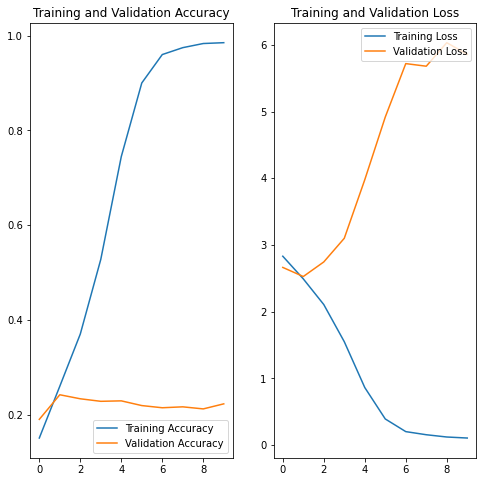

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


The validation accuracy tapers off slightly above 0.2, while the training accuracy quickly approaches 1.0.

This is clear evidence of overfitting.

# Image classification with k Nearest Neighbors

There is another well-researched and well-known model for image classification: k Nearest Neighbors.

For the sake of comparison, lets see how well k-NN works versus the previous model (neural network).

We expect k-NN to be much less accurate than NN, because it uses a simpler solution for a complicated problem.

k-NN works by measuring the distance of a test image vector from its k closest examples in the training set: "Tell me who your neighbors are, and I'll tell you who you are".

We use two different feature sets: raw pixel data and color histograms.

In [ ]:
RUN_KNN = False

In [ ]:
if RUN_KNN:
  #https://www.pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification/

  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.model_selection import train_test_split
  from imutils import paths
  import numpy as np
  import argparse
  import imutils
  import cv2
  import os
  from glob import glob


  def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()
  

  def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
      [0, 180, 0, 256, 0, 256])
    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
      hist = cv2.normalize(hist)
    # otherwise, perform "in place" normalization in OpenCV 3 (I
    # personally hate the way this is done
    else:
      cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()
  
  neighbors = 20
  jobs = -1

  # grab the list of images that we'll be describing
  print("[INFO] describing images...")
  imagePaths = glob(str(images_path) + '/**/*.*')
  # import random
  # random.shuffle(imagePaths)
  # imagePaths = imagePaths[:1000]
  # initialize the raw pixel intensities matrix, the features matrix,
  # and labels list
  rawImages = []
  features = []
  labels = []


  # loop over the input images
  for (i, imagePath) in enumerate(imagePaths):
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-2].split(".")[0]
    # extract raw pixel intensity "features", followed by a color
    # histogram to characterize the color distribution of the pixels
    # in the image
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
    # update the raw images, features, and labels matricies,
    # respectively
    rawImages.append(pixels)
    features.append(hist)
    labels.append(label)
    # show an update every 1,000 images
    if i > 0 and i % 1000 == 0:
      print("[INFO] processed {}/{}".format(i, len(imagePaths)))
    

  # show some information on the memory consumed by the raw images
  # matrix and features matrix
  rawImages = np.array(rawImages)
  features = np.array(features)
  labels = np.array(labels)
  print("[INFO] pixels matrix: {:.2f}MB".format(
    rawImages.nbytes / (1024 * 1000.0)))
  print("[INFO] features matrix: {:.2f}MB".format(
    features.nbytes / (1024 * 1000.0)))


  # partition the data into training and testing splits, using 75%
  # of the data for training and the remaining 25% for testing
  (trainRI, testRI, trainRL, testRL) = train_test_split(
    rawImages, labels, test_size=0.25, random_state=42)
  (trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
    features, labels, test_size=0.25, random_state=42)


  # train and evaluate a k-NN classifer on the raw pixel intensities
  print("[INFO] evaluating raw pixel accuracy...")
  model = KNeighborsClassifier(n_neighbors=neighbors, n_jobs=jobs)
  model.fit(trainRI, trainRL)
  acc = model.score(testRI, testRL)
  print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))

  # train and evaluate a k-NN classifer on the histogram
  # representations
  print("[INFO] evaluating histogram accuracy...")
  model = KNeighborsClassifier(n_neighbors=neighbors, n_jobs=jobs)
  model.fit(trainFeat, trainLabels)
  acc = model.score(testFeat, testLabels)
  print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))

[INFO] describing images...
[INFO] processed 1000/20627
[INFO] processed 2000/20627
[INFO] processed 3000/20627
[INFO] processed 4000/20627
[INFO] processed 5000/20627
[INFO] processed 6000/20627
[INFO] processed 7000/20627
[INFO] processed 8000/20627
[INFO] processed 9000/20627
[INFO] processed 10000/20627
[INFO] processed 11000/20627
[INFO] processed 12000/20627
[INFO] processed 13000/20627
[INFO] processed 14000/20627
[INFO] processed 15000/20627
[INFO] processed 16000/20627
[INFO] processed 17000/20627
[INFO] processed 18000/20627
[INFO] processed 19000/20627
[INFO] processed 20000/20627
[INFO] pixels matrix: 61.88MB
[INFO] features matrix: 41.25MB
[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 10.01%
[INFO] evaluating histogram accuracy...
[INFO] histogram accuracy: 12.10%


Since the above code takes a long time to run, we won't run it again here, and instead we will copy-paste it's output in the following markdown cell:

    [INFO] describing images...
    [INFO] processed 1000/20627
    [INFO] processed 2000/20627
    [INFO] processed 3000/20627
    [INFO] processed 4000/20627
    [INFO] processed 5000/20627
    [INFO] processed 6000/20627
    [INFO] processed 7000/20627
    [INFO] processed 8000/20627
    [INFO] processed 9000/20627
    [INFO] processed 10000/20627
    [INFO] processed 11000/20627
    [INFO] processed 12000/20627
    [INFO] processed 13000/20627
    [INFO] processed 14000/20627
    [INFO] processed 15000/20627
    [INFO] processed 16000/20627
    [INFO] processed 17000/20627
    [INFO] processed 18000/20627
    [INFO] processed 19000/20627
    [INFO] processed 20000/20627
    [INFO] pixels matrix: 61.88MB
    [INFO] features matrix: 41.25MB
    [INFO] evaluating raw pixel accuracy...
    [INFO] raw pixel accuracy: 10.01%
    [INFO] evaluating histogram accuracy...
    [INFO] histogram accuracy: 12.10%

As expected, the accuracy of both k-NN models (raw pixels data, and color histograms) is poor. Yet we can conclude from the slightly better performance of the color histograms that the color is an important predictor in our data that we cannot ignore.


#Image classification with ImageAI

ImageAI is another library that allows to easily implement the ResNet50 neural network model.

Let's see how well it performs:

First we split the data into the train and test directories as the library expects:

In [ ]:
import random
import math
import shutil
import os
from pathlib import Path

cwd = os.getcwd()

SPLIT_PERCENTAGE = 0.2

subreddits = subreddits_to_keep

p3 = Path(cwd + '/images3')
p3.mkdir(parents=True, exist_ok=True)

p3_test = Path(str(p3) + '/test')
p3_test.mkdir(parents=True, exist_ok=True)

p3_train = Path(str(p3) + '/train')
p3_train.mkdir(parents=True, exist_ok=True)


for sub in subreddits:
  random.seed(1)
  sub_path1 = Path(cwd + '/images/' + sub)
  files = os.listdir(sub_path1)
  random.shuffle(files)
  num_files = len(files)
  split_point = math.floor(num_files * SPLIT_PERCENTAGE)
  test = files[:split_point]
  train = files[split_point+1:]
  print(f'Num test files in sub {sub}: {len(test)}')
  print(f'Num train files in sub {sub}: {len(train)}')
  tt = ['test', 'train']
  for t, t_data, t_path in zip(tt, [test, train], [p3_test, p3_train]):
    sub_path = Path(str(t_path) +'/' + sub)
    sub_path.mkdir(parents=True, exist_ok=True)
    for f in t_data:
      image_soruce_path = str(sub_path1) + '/' + f
      image_target_path = str(sub_path) + '/' + f
      shutil.copy(image_soruce_path, image_target_path)


Num test files in sub FromKittenToCat: 160
Num train files in sub FromKittenToCat: 643
Num test files in sub Kitty: 180
Num train files in sub Kitty: 719
Num test files in sub Floof: 179
Num train files in sub Floof: 717
Num test files in sub CatsSittingDown: 178
Num train files in sub CatsSittingDown: 713
Num test files in sub BattleCats: 182
Num train files in sub BattleCats: 731
Num test files in sub JellybeanToes: 178
Num train files in sub JellybeanToes: 711
Num test files in sub CatLoaf: 186
Num train files in sub CatLoaf: 744
Num test files in sub scrungycats: 182
Num train files in sub scrungycats: 729
Num test files in sub PottedCats: 181
Num train files in sub PottedCats: 723
Num test files in sub blurrypicturesofcats: 192
Num train files in sub blurrypicturesofcats: 768
Num test files in sub catfruit: 178
Num train files in sub catfruit: 712
Num test files in sub TuxedoCats: 183
Num train files in sub TuxedoCats: 733
Num test files in sub CatPictures: 182
Num train files in 

We install the library itself:

In [ ]:
!pip install imageai --upgrade

     |████████████████████████████████| 163kB 4.5MB/s 
     |████████████████████████████████| 2.9MB 31.1MB/s 
     |████████████████████████████████| 14.9MB 350kB/s 
     |████████████████████████████████| 11.6MB 32.0MB/s 
     |████████████████████████████████| 2.1MB 22.8MB/s 
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=141ece6ccf14533203500555f328f8dbd44c8c2d25db8496b91ba42f1a2a3794
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-resnet
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: bokeh 2.3.2 has requirement pillow>=7.1.0, but you'll have pillow 7.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 whic

Then we train the model:

In [ ]:
RUN_IMAGEAI_MODEL = False

Since running the model takes many hours, we won't run it again here, and we will instead copy-paste its output in the markdown cell after the code cell:

In [ ]:
if RUN_IMAGEAI_MODEL:
  from imageai.Classification.Custom import ClassificationModelTrainer

  num_objects = len(subreddits_to_keep)

  model_trainer = ClassificationModelTrainer()
  model_trainer.setModelTypeAsResNet50()
  model_trainer.setDataDirectory('images3')
  model_trainer.trainModel(num_objects=num_objects, num_experiments=5, enhance_data=True, batch_size=32, show_network_summary=True)

    Model: "model"
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
    __________________________________________________________________________________________________
    conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
    __________________________________________________________________________________________________
    conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
    __________________________________________________________________________________________________
    conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
    __________________________________________________________________________________________________
    conv1_relu (Activation)         (None, 112, 112, 64) 0           conv1_bn[0][0]                   
    __________________________________________________________________________________________________
    pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_relu[0][0]                 
    __________________________________________________________________________________________________
    pool1_pool (MaxPooling2D)       (None, 56, 56, 64)   0           pool1_pad[0][0]                  
    __________________________________________________________________________________________________
    conv2_block1_1_conv (Conv2D)    (None, 56, 56, 64)   4160        pool1_pool[0][0]                 
    __________________________________________________________________________________________________
    conv2_block1_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block1_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv2_block1_1_relu (Activation (None, 56, 56, 64)   0           conv2_block1_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv2_block1_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block1_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv2_block1_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block1_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv2_block1_2_relu (Activation (None, 56, 56, 64)   0           conv2_block1_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv2_block1_0_conv (Conv2D)    (None, 56, 56, 256)  16640       pool1_pool[0][0]                 
    __________________________________________________________________________________________________
    conv2_block1_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block1_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv2_block1_0_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block1_0_conv[0][0]        
    __________________________________________________________________________________________________
    conv2_block1_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block1_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv2_block1_add (Add)          (None, 56, 56, 256)  0           conv2_block1_0_bn[0][0]          
                                                                    conv2_block1_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv2_block1_out (Activation)   (None, 56, 56, 256)  0           conv2_block1_add[0][0]           
    __________________________________________________________________________________________________
    conv2_block2_1_conv (Conv2D)    (None, 56, 56, 64)   16448       conv2_block1_out[0][0]           
    __________________________________________________________________________________________________
    conv2_block2_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block2_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv2_block2_1_relu (Activation (None, 56, 56, 64)   0           conv2_block2_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv2_block2_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block2_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv2_block2_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block2_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv2_block2_2_relu (Activation (None, 56, 56, 64)   0           conv2_block2_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv2_block2_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block2_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv2_block2_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block2_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv2_block2_add (Add)          (None, 56, 56, 256)  0           conv2_block1_out[0][0]           
                                                                    conv2_block2_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv2_block2_out (Activation)   (None, 56, 56, 256)  0           conv2_block2_add[0][0]           
    __________________________________________________________________________________________________
    conv2_block3_1_conv (Conv2D)    (None, 56, 56, 64)   16448       conv2_block2_out[0][0]           
    __________________________________________________________________________________________________
    conv2_block3_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block3_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv2_block3_1_relu (Activation (None, 56, 56, 64)   0           conv2_block3_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv2_block3_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block3_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv2_block3_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block3_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv2_block3_2_relu (Activation (None, 56, 56, 64)   0           conv2_block3_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv2_block3_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block3_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv2_block3_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block3_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv2_block3_add (Add)          (None, 56, 56, 256)  0           conv2_block2_out[0][0]           
                                                                    conv2_block3_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv2_block3_out (Activation)   (None, 56, 56, 256)  0           conv2_block3_add[0][0]           
    __________________________________________________________________________________________________
    conv3_block1_1_conv (Conv2D)    (None, 28, 28, 128)  32896       conv2_block3_out[0][0]           
    __________________________________________________________________________________________________
    conv3_block1_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block1_1_relu (Activation (None, 28, 28, 128)  0           conv3_block1_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block1_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block1_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv3_block1_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block1_2_relu (Activation (None, 28, 28, 128)  0           conv3_block1_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block1_0_conv (Conv2D)    (None, 28, 28, 512)  131584      conv2_block3_out[0][0]           
    __________________________________________________________________________________________________
    conv3_block1_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block1_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv3_block1_0_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block1_0_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block1_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block1_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block1_add (Add)          (None, 28, 28, 512)  0           conv3_block1_0_bn[0][0]          
                                                                    conv3_block1_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block1_out (Activation)   (None, 28, 28, 512)  0           conv3_block1_add[0][0]           
    __________________________________________________________________________________________________
    conv3_block2_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block1_out[0][0]           
    __________________________________________________________________________________________________
    conv3_block2_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block2_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block2_1_relu (Activation (None, 28, 28, 128)  0           conv3_block2_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block2_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block2_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv3_block2_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block2_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block2_2_relu (Activation (None, 28, 28, 128)  0           conv3_block2_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block2_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block2_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv3_block2_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block2_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block2_add (Add)          (None, 28, 28, 512)  0           conv3_block1_out[0][0]           
                                                                    conv3_block2_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block2_out (Activation)   (None, 28, 28, 512)  0           conv3_block2_add[0][0]           
    __________________________________________________________________________________________________
    conv3_block3_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block2_out[0][0]           
    __________________________________________________________________________________________________
    conv3_block3_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block3_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block3_1_relu (Activation (None, 28, 28, 128)  0           conv3_block3_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block3_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block3_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv3_block3_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block3_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block3_2_relu (Activation (None, 28, 28, 128)  0           conv3_block3_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block3_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block3_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv3_block3_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block3_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block3_add (Add)          (None, 28, 28, 512)  0           conv3_block2_out[0][0]           
                                                                    conv3_block3_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block3_out (Activation)   (None, 28, 28, 512)  0           conv3_block3_add[0][0]           
    __________________________________________________________________________________________________
    conv3_block4_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block3_out[0][0]           
    __________________________________________________________________________________________________
    conv3_block4_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block4_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block4_1_relu (Activation (None, 28, 28, 128)  0           conv3_block4_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block4_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block4_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv3_block4_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block4_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block4_2_relu (Activation (None, 28, 28, 128)  0           conv3_block4_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block4_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block4_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
                                                                    conv3_block4_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
    __________________________________________________________________________________________________
    conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
    __________________________________________________________________________________________________
    conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block1_0_conv (Conv2D)    (None, 14, 14, 1024) 525312      conv3_block4_out[0][0]           
    __________________________________________________________________________________________________
    conv4_block1_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block1_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block1_0_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_0_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block1_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block1_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_0_bn[0][0]          
                                                                    conv4_block1_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block1_out (Activation)   (None, 14, 14, 1024) 0           conv4_block1_add[0][0]           
    __________________________________________________________________________________________________
    conv4_block2_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block1_out[0][0]           
    __________________________________________________________________________________________________
    conv4_block2_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block2_1_relu (Activation (None, 14, 14, 256)  0           conv4_block2_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block2_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block2_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block2_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block2_2_relu (Activation (None, 14, 14, 256)  0           conv4_block2_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block2_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block2_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block2_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block2_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block2_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_out[0][0]           
                                                                    conv4_block2_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block2_out (Activation)   (None, 14, 14, 1024) 0           conv4_block2_add[0][0]           
    __________________________________________________________________________________________________
    conv4_block3_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block2_out[0][0]           
    __________________________________________________________________________________________________
    conv4_block3_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block3_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block3_1_relu (Activation (None, 14, 14, 256)  0           conv4_block3_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block3_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block3_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block3_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block3_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block3_2_relu (Activation (None, 14, 14, 256)  0           conv4_block3_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block3_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block3_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block3_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block3_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block3_add (Add)          (None, 14, 14, 1024) 0           conv4_block2_out[0][0]           
                                                                    conv4_block3_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block3_out (Activation)   (None, 14, 14, 1024) 0           conv4_block3_add[0][0]           
    __________________________________________________________________________________________________
    conv4_block4_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block3_out[0][0]           
    __________________________________________________________________________________________________
    conv4_block4_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block4_1_relu (Activation (None, 14, 14, 256)  0           conv4_block4_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block4_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block4_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block4_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block4_2_relu (Activation (None, 14, 14, 256)  0           conv4_block4_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block4_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block4_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block4_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block4_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block4_add (Add)          (None, 14, 14, 1024) 0           conv4_block3_out[0][0]           
                                                                    conv4_block4_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block4_out (Activation)   (None, 14, 14, 1024) 0           conv4_block4_add[0][0]           
    __________________________________________________________________________________________________
    conv4_block5_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block4_out[0][0]           
    __________________________________________________________________________________________________
    conv4_block5_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block5_1_relu (Activation (None, 14, 14, 256)  0           conv4_block5_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block5_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block5_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block5_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block5_2_relu (Activation (None, 14, 14, 256)  0           conv4_block5_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block5_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block5_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block5_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block5_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block5_add (Add)          (None, 14, 14, 1024) 0           conv4_block4_out[0][0]           
                                                                    conv4_block5_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block5_out (Activation)   (None, 14, 14, 1024) 0           conv4_block5_add[0][0]           
    __________________________________________________________________________________________________
    conv4_block6_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block5_out[0][0]           
    __________________________________________________________________________________________________
    conv4_block6_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block6_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block6_1_relu (Activation (None, 14, 14, 256)  0           conv4_block6_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block6_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block6_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block6_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block6_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block6_2_relu (Activation (None, 14, 14, 256)  0           conv4_block6_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block6_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block6_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv4_block6_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block6_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv4_block6_add (Add)          (None, 14, 14, 1024) 0           conv4_block5_out[0][0]           
                                                                    conv4_block6_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv4_block6_out (Activation)   (None, 14, 14, 1024) 0           conv4_block6_add[0][0]           
    __________________________________________________________________________________________________
    conv5_block1_1_conv (Conv2D)    (None, 7, 7, 512)    524800      conv4_block6_out[0][0]           
    __________________________________________________________________________________________________
    conv5_block1_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block1_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv5_block1_1_relu (Activation (None, 7, 7, 512)    0           conv5_block1_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv5_block1_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block1_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv5_block1_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block1_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv5_block1_2_relu (Activation (None, 7, 7, 512)    0           conv5_block1_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv5_block1_0_conv (Conv2D)    (None, 7, 7, 2048)   2099200     conv4_block6_out[0][0]           
    __________________________________________________________________________________________________
    conv5_block1_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block1_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv5_block1_0_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block1_0_conv[0][0]        
    __________________________________________________________________________________________________
    conv5_block1_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block1_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv5_block1_add (Add)          (None, 7, 7, 2048)   0           conv5_block1_0_bn[0][0]          
                                                                    conv5_block1_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv5_block1_out (Activation)   (None, 7, 7, 2048)   0           conv5_block1_add[0][0]           
    __________________________________________________________________________________________________
    conv5_block2_1_conv (Conv2D)    (None, 7, 7, 512)    1049088     conv5_block1_out[0][0]           
    __________________________________________________________________________________________________
    conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv5_block2_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block2_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv5_block2_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block2_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv5_block2_add (Add)          (None, 7, 7, 2048)   0           conv5_block1_out[0][0]           
                                                                    conv5_block2_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv5_block2_out (Activation)   (None, 7, 7, 2048)   0           conv5_block2_add[0][0]           
    __________________________________________________________________________________________________
    conv5_block3_1_conv (Conv2D)    (None, 7, 7, 512)    1049088     conv5_block2_out[0][0]           
    __________________________________________________________________________________________________
    conv5_block3_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block3_1_conv[0][0]        
    __________________________________________________________________________________________________
    conv5_block3_1_relu (Activation (None, 7, 7, 512)    0           conv5_block3_1_bn[0][0]          
    __________________________________________________________________________________________________
    conv5_block3_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block3_1_relu[0][0]        
    __________________________________________________________________________________________________
    conv5_block3_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block3_2_conv[0][0]        
    __________________________________________________________________________________________________
    conv5_block3_2_relu (Activation (None, 7, 7, 512)    0           conv5_block3_2_bn[0][0]          
    __________________________________________________________________________________________________
    conv5_block3_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block3_2_relu[0][0]        
    __________________________________________________________________________________________________
    conv5_block3_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block3_3_conv[0][0]        
    __________________________________________________________________________________________________
    conv5_block3_add (Add)          (None, 7, 7, 2048)   0           conv5_block2_out[0][0]           
                                                                    conv5_block3_3_bn[0][0]          
    __________________________________________________________________________________________________
    conv5_block3_out (Activation)   (None, 7, 7, 2048)   0           conv5_block3_add[0][0]           
    __________________________________________________________________________________________________
    avg_pool (GlobalAveragePooling2 (None, 2048)         0           conv5_block3_out[0][0]           
    __________________________________________________________________________________________________
    dense_6 (Dense)                 (None, 23)           47127       avg_pool[0][0]                   
    ==================================================================================================
    Total params: 23,634,839
    Trainable params: 23,581,719
    Non-trainable params: 53,120
    __________________________________________________________________________________________________
    Using Enhanced Data Generation
    Found 16472 images belonging to 23 classes.
    Found 4113 images belonging to 23 classes.
    JSON Mapping for the model classes saved to  images3/json/model_class.json
    Number of experiments (Epochs) :  5

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
      warnings.warn('`Model.fit_generator` is deprecated and '

    Epoch 1/5
    152/514 [=======>......................] - ETA: 18:42 - loss: 3.8961 - accuracy: 0.0697

    /opt/conda/lib/python3.7/site-packages/PIL/Image.py:2835: DecompressionBombWarning: Image size (99532800 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
      return im

    514/514 [==============================] - 1990s 4s/step - loss: 3.4461 - accuracy: 0.0888 - val_loss: 2.9998 - val_accuracy: 0.1172

    Epoch 00001: accuracy improved from -inf to 0.10949, saving model to images3/models/model_ex-001_acc-0.109489.h5
    Epoch 2/5
    514/514 [==============================] - 1995s 4s/step - loss: 2.8355 - accuracy: 0.1553 - val_loss: 2.7300 - val_accuracy: 0.1978

    Epoch 00002: accuracy improved from 0.10949 to 0.16393, saving model to images3/models/model_ex-002_acc-0.163929.h5
    Epoch 3/5
    514/514 [==============================] - 1976s 4s/step - loss: 2.7168 - accuracy: 0.1916 - val_loss: 3.5592 - val_accuracy: 0.1309

    Epoch 00003: accuracy improved from 0.16393 to 0.19562, saving model to images3/models/model_ex-003_acc-0.195620.h5
    Epoch 4/5
    514/514 [==============================] - 1983s 4s/step - loss: 2.5447 - accuracy: 0.2328 - val_loss: 2.4956 - val_accuracy: 0.2439

    Epoch 00004: accuracy improved from 0.19562 to 0.24288, saving model to images3/models/model_ex-004_acc-0.242883.h5
    Epoch 5/5
    514/514 [==============================] - 2004s 4s/step - loss: 2.4426 - accuracy: 0.2581 - val_loss: 2.4584 - val_accuracy: 0.2600

    Epoch 00005: accuracy improved from 0.24288 to 0.25973, saving model to images3/models/model_ex-005_acc-0.259732.h5


Let's use the trained model to predict the same cat images we tried on the previous models:

In [ ]:
if RUN_IMAGEAI_MODEL:
  from imageai.Classification.Custom import CustomImageClassification
  import os

  execution_path = os.getcwd()

  prediction = CustomImageClassification()
  prediction.setModelTypeAsResNet50()
  prediction.setModelPath("images3_061-0.7933.h5")
  prediction.setJsonPath("images3_model_class.json")
  prediction.loadModel(num_objects=num_objects)


  cat1_url = "https://upload.wikimedia.org/wikipedia/commons/e/e8/Sphinx2_July_2006.jpg"
  cat2_url = "https://upload.wikimedia.org/wikipedia/commons/4/4c/Blackcat-Lilith.jpg"
  urllib.request.urlretrieve(url=cat1_url, filename='cat1.jpg')
  urllib.request.urlretrieve(url=cat2_url, filename='cat2.jpg')


  predictions1, probabilities1 = prediction.predictImage("cat1.jpg", result_count=3)
  predictions2, probabilities2 = prediction.predictImage("cat2.jpg", result_count=3)

  print('Cat 1 predictions:')
  for eachPrediction, eachProbability in zip(predictions1, probabilities1):
      print(eachPrediction , " : " , eachProbability)

  print('#' * 30)

  print('Cat 2 predictions:')
  for eachPrediction, eachProbability in zip(predictions2, probabilities2):
      print(eachPrediction , " : " , eachProbability)


Again, in lieu of running the model, here is the copy-pasted output in a markdown cell:

    Cat 1 predictions:
    BattleCats  :  100.0
    Kitty  :  0.0
    BlackCats  :  0.0
    CatLoaf  :  0.0
    CatMemes  :  0.0
    ##############################
    Cat 2 predictions:
    BattleCats  :  100.0
    Kitty  :  0.0
    BlackCats  :  0.0
    CatLoaf  :  0.0
    CatMemes  :  0.0

The ImageAI model we just trained has just miscategorized both cat images with 100% confidence, a disappointin result.

This was to be was expected, since the final `val_accuracy` of the model was just 0.2600.

This is still better than pure chance; there are 23 classes of cat subreddits, and picking one at random would yield succes $\frac{1}{23} \approx 0.043$ of the time, which is smaller by a factor 6 compared to the model's accuracy.



#Conclusions

The original intention of this project was to create a reddit bot `u/CATegorizer_bot` that would automatically reply to submissions of cat pictures and suggest other subreddits that the submission might fit in.

None of the models we built produced sufficiently accurate results to move forward with this origina plan, even when we limited the image classification problem to only the 23 most popular cat subreddits; so the bot remains unrealized.

However, the model that only had to contend with two types of cat images: `SphynxCats` and `BlackCats`, produced an accuracy of over 80%, which gives us hope that it may still be possible to build a model that would work for the full scale CATegorization problem.

Each of our more ambitious models suffered from overfitting, despite having relatively simple models.
We believe the core problem is a lack of data: each subreddit had only up to 1000 image examples for the algorithm to study.

This limitation of 1000 image examples per subreddit arised from technical limitations of the scraping tool we built, which could only query the top 1000 highly-upvoted images because of reddit's API limitations.

Even if we could mine more data from reddit, it would've taken an infeasable amount of time to do so (just the data we gathered took approximately 4 days of scraping to gather), our limited computing resources would make it impossible to *use* all that data.

Another aspect that might've contributed the low accuracy, combined with the lack of data, is imperfectly labeled data. Reddit users often overlook the subreddit they're browsing and just enjoy seeing pictures of cats, regardless of whether they fit the subreddit or not. This results in mislabeled data on our part, since an image that does not carry the properties of a certain subreddit might still appear in that subreddit.

<!-- A third aspect that may have contributed to the failure of our models, is that they do not account for the fact that some images are members of multiple classes: a single image may be appropriate for several different subreddits. The best example for this is the most general subreddit [r/cats](https://www.reddit.com/r/cats/top), which intersects with all other subreddits in our scope.
We lacked the technical capability of associating images as being part of several classes.

We delibirately didn't choose the "easy" subreddits to classify because we did want to try something differet - there's a lot of other models that try to differentiate  -->

We conclude with a selection of images from our favorite subreddit [r/purrito](https://www.reddit.com/r/purrito/top)

<table>
<tr>
  <td><img src="https://i.redd.it/89qq130qgif61.jpg" width = 360px height = 300px></td>
  <td><img src="https://i.redd.it/7ys91p10hhh61.jpg" width = 360px height = 300px></td>
  <td><img src="https://i.redd.it/49ji688cyvh61.jpg" width = 360px height = 300px></td>
</tr> 
<tr>
  <td><img src="https://i.redd.it/u5xowil7hjw61.png" width = 360px height = 300px></td>
  <td><img src="https://i.redd.it/2er2wt0e6oz61.jpg" width = 360px height = 300px></td>
  <td><img src="https://i.redd.it/kxoidzq688161.jpg" width = 360px height = 300px></td>
</tr>
</table>